Principal Component Analysis is an unsupervised method for reducing the dimensionality so that it can be fed into regression. This notebook explores the algorithm and visualises the result.

## Pricincipal Component Analysis (PCA)

Let's dig into PCA first. Unlike Lasso, PCA transforms existing data into new features. It reduces dimensionality (amount of features), while still explaining good part of the dataset variability. These new features are then fed into linear regression.

In [4]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer,PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import stars
from matplotlib import animation


mlflow.sklearn.autolog()
mlflow.set_experiment("/mastar/07_other_models")

hot_id = 61
cold_id = 58

In [5]:
sl = stars.StarLoader()

In [6]:
goodt = sl.get_goodt()
df_goodt = sl.fits_to_pd(goodt)

seed = 1
training_features_all, testing_features_all, training_target, testing_target = train_test_split(df_goodt, df_goodt['teff'], random_state=seed)

mangaid_training = training_features_all['mangaid']
mangaid_testing = testing_features_all['mangaid']
training_features = np.array(training_features_all.drop(['mangaid', 'teff', 'teff_ext'], axis=1))
testing_features = np.array(testing_features_all.drop(['mangaid', 'teff', 'teff_ext'], axis=1))

In [7]:
pca = PCA(n_components=50)
lin = LinearRegression()
pipeline = make_pipeline(
    Normalizer(norm="l2" ),
    pca,
    lin,
    verbose=True
)
pipeline.fit(training_features, training_target)

results = pipeline.predict(testing_features)
mse = mean_squared_error(testing_target, results)
print('MSE: %.2f' % mse)

2022/10/15 16:50:15 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '28f433e36ecd4c85a69292a1eda8439b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


[Pipeline] ........ (step 1 of 3) Processing normalizer, total=   0.1s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.5s
[Pipeline] .. (step 3 of 3) Processing linearregression, total=   0.0s


2022/10/15 16:50:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/x/opt/miniconda3/envs/mastar/lib/python3.10/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils."


MSE: 62904.62


In [8]:
badt_lim = sl.get_badt_lim()
df_badt_lim = sl.fits_to_pd(badt_lim)
target_ext = df_badt_lim['teff_ext']

results_ext = pipeline.predict(np.array(df_badt_lim.drop(['mangaid', 'teff', 'teff_ext'], axis=1)))
mse = mean_squared_error(target_ext, results_ext)
print('External dataset MSE: %.2f' % mse)

External dataset MSE: 30432.89


Results are roughly similar to Lasso, but with much improved fitting time - PCA+linear regression took just 1 second to fit compared with more than 30 seconds for lasso!

3 dimensions resulted in a MSE of 280,000. 5 dimensions were also insufficient to produce a good model (MSE ~200,000). Moderately good result can be achieved by using just 20 dimensions (MSE ~87,000). As we add dimensions, MSE improves but with diminishing returns - it roughly matches lasso at 50 dimensions (~63,000). At 100 it slightly improves to ~56,000, which is beyond what lasso could do. At 200 it improves even more, but at this point the MSE of the external comparison starts to creep up, which I take to mean we are now well into overfitting territory. I leave plotting this data as a bias-variance tradeoff excercise for the reader ;-)

Main drawback of PCA+linear regression is that the addition of the transform makes it harder to reason about what's going on (which we've barely been able to do with lasso).

Let's try to make sense of how this actually works. Let's plot the first couple of strongest components coming out of the PCA against two sample stars (hot and cold) to see how they look like.

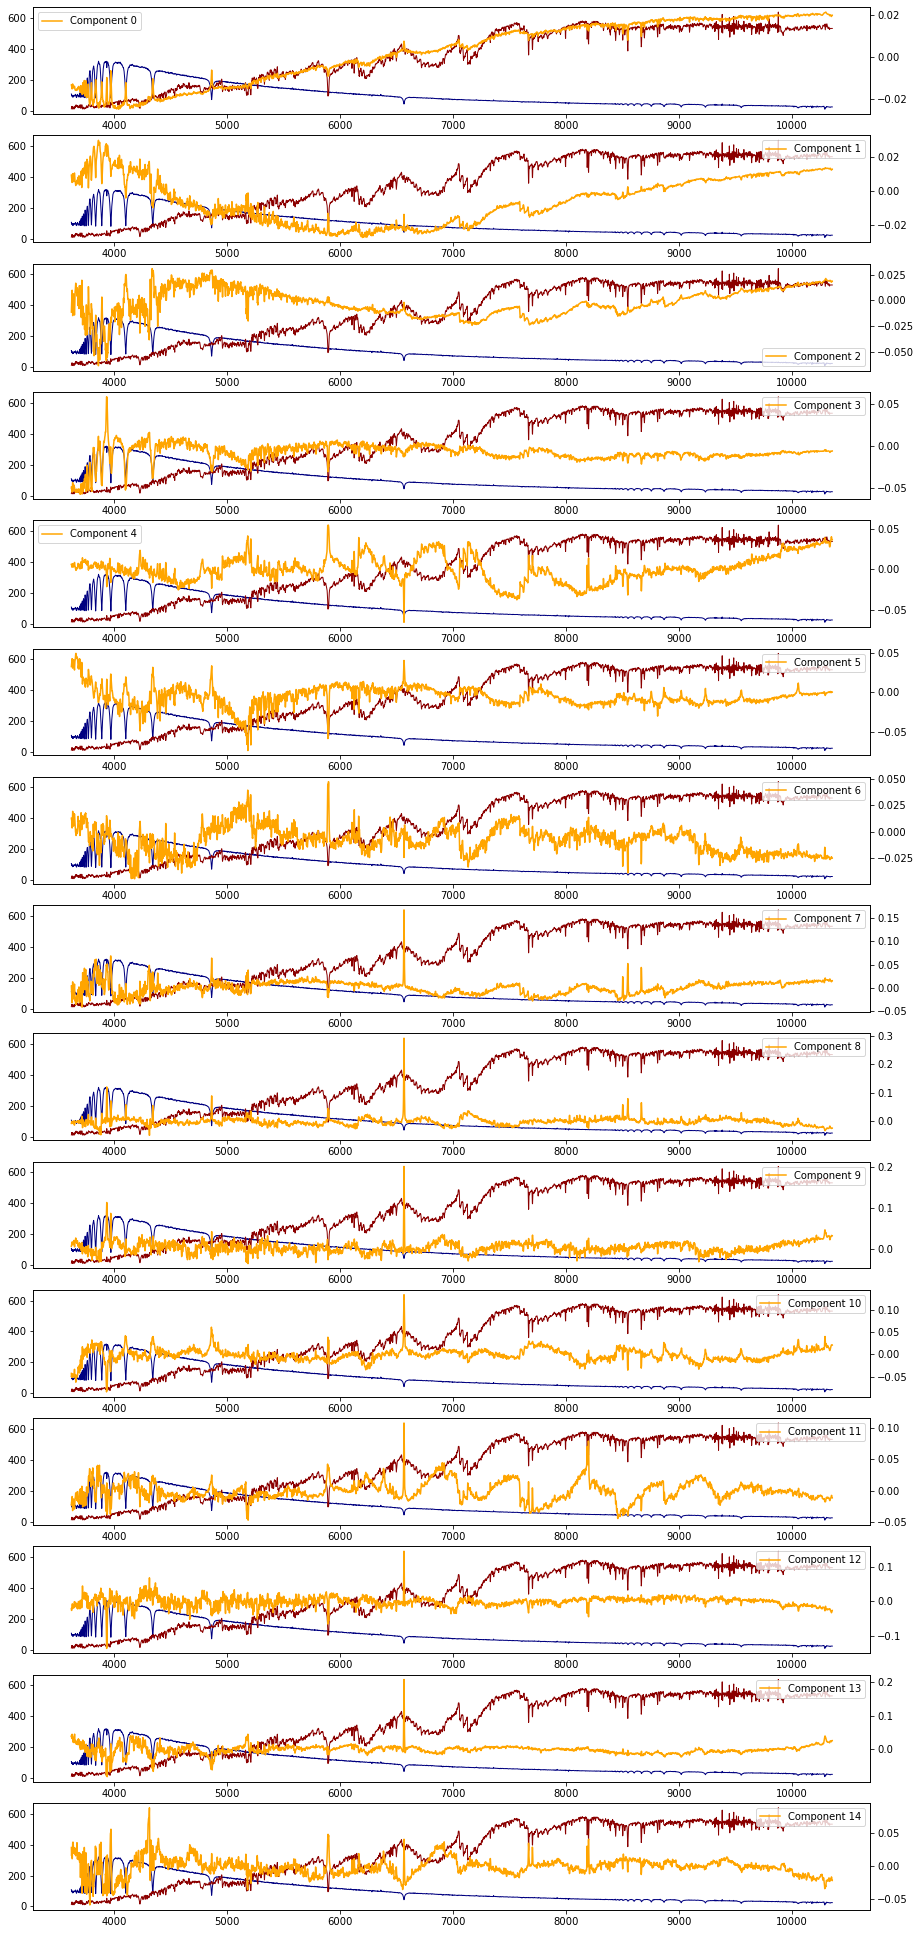

In [9]:
angstroms = sl.get_angstroms()
coef = pca.components_

def plot_component(n, ax):
    ax.plot(angstroms, goodt[hot_id]['FLUX_CORR'], color='navy', linewidth=1)
    ax.plot(angstroms, goodt[cold_id]['FLUX_CORR'], color='darkred', linewidth=1)
    ax2 = ax.twinx()
    ax2.yaxis.tick_right()
    ax2.plot(angstroms, coef[n], color='orange', label="Component %d" % n)
    ax2.legend()

fig,ax = plt.subplots(15, figsize=(15,35))
for c in np.arange(0, 15, 1):
    plot_component(c, ax[c])

plt.show()


We can see PCA is remixing available dimensions. For example first component (the one that explains the most variance in the training dataset) mixes features from both hot (absorption lines on the left) and cold stars (general slope). Specific original features can also be recognised in the following components, albeit with more difficulty.

First three components follow the general slope of the spectra, but as we increase the component number, the components seem to be focusing more and more on smaller features. Component 13 for example seems to be very keen on capturing absorption lines. I take it to mean that the further we go down components, the more specialised they get.

This is not the end of the story though: linear regression assigns weights to these components. Let's see the regression coefficients.

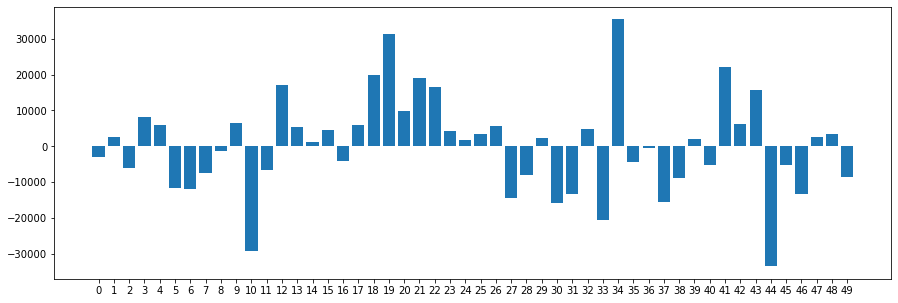

In [10]:
fig,ax = plt.subplots(figsize=(15,5))
ax.bar(np.arange(0,50,1), lin.coef_)
ax.set_xticks(np.arange(0,50,1))
plt.show()

How do we reason about this? We know early components correlate with spectrum slopes, but linear regression assigns high weights to the more specialised components down the line. Component 34 for example is strongly (positively) correlated with temperature. I'd expect it then to be particularly good at spotting something special: likely absorption lines. Let's see.

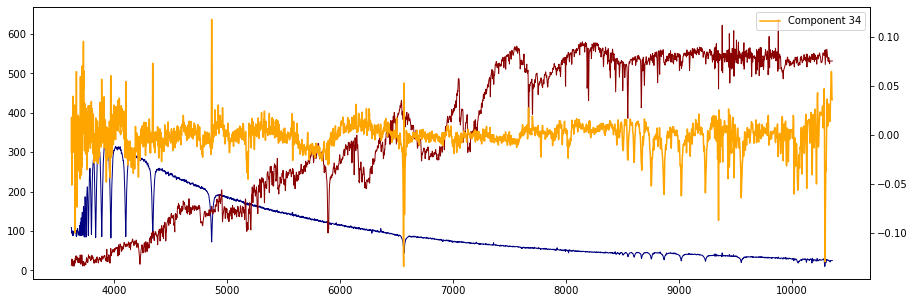

In [11]:
fig,ax = plt.subplots(figsize=(15,5))
plot_component(34, ax)
plt.show()

This seems to be particularly keen on amplifying blue-star absorption lines. And how about the most negatively correlated component (44)?

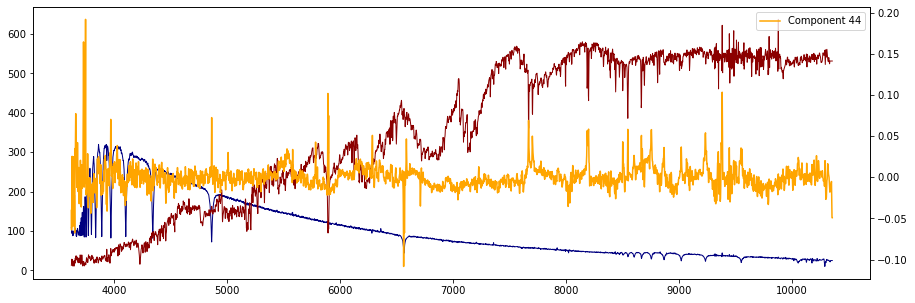

In [12]:
fig,ax = plt.subplots(figsize=(15,5))
plot_component(44, ax)
plt.show()

This correlates with... something else - it's hard to decide.

I think what happens here, is that because as the components get more specialised down the line, regression has to assign comparatively higher weights to get sufficient signal. I think the opposite is true for the first few slope-matching components: because they expect to match most of the spectrum, they can make do with relatively small regression coefficients.

If we recall earlier note on MSE vs PCA dimension effects (good results beyond 20 components), then I take it to mean that to achieve good results, this regressor has to look both at the general slope of the spectrum (represented by the first few components) but also at some specific features (represented by components down the line).